In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time, datetime

In [2]:
def timeit(f, caption=""):
    now=time.time()
    r=f()
    duration = duration = str(datetime.timedelta(seconds=time.time()-now))
    print(caption+(" - " if(len(caption)>0) else "")+duration)
    return r

In [3]:
project="injenia-ricerca"

# null values
Partially based on https://www.linkedin.com/pulse/predicting-taxi-fare-chicago-cabs-thomas-synnott

In [88]:
label_cols=["trip_total", "trip_seconds"]

<AxesSubplot:xlabel='column'>

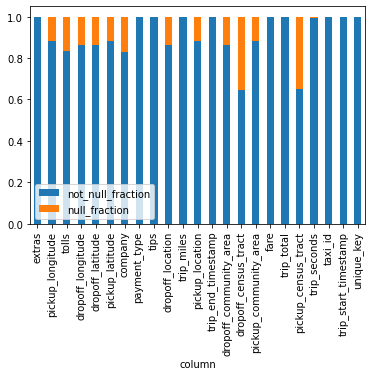

In [73]:
columns = [
    "trip_total",
    "trip_seconds",
    "unique_key",
    "taxi_id",
    "trip_start_timestamp",
    "trip_end_timestamp",
    "trip_miles",
    "pickup_census_tract",
    "dropoff_census_tract",
    "pickup_community_area",
    "dropoff_community_area",
    "fare",
    "tips",
    "tolls",
    "extras",
    "payment_type",
    "company",
    "pickup_latitude",
    "pickup_longitude",
    "pickup_location",
    "dropoff_latitude",
    "dropoff_longitude",
    "dropoff_location"
]
query = """
select * from (
"""+" UNION ALL \n".join([
    f"""(select "{c}"  as column, COUNTIF({c} is null) as null_count, COUNTIF({c} is not null) as not_null_count, COUNTIF({c} is null)/count(*) as null_fraction, COUNTIF({c} is not null)/count(*) as not_null_fraction from `bigquery-public-data.chicago_taxi_trips.taxi_trips`)"""
    for c in columns
])+""")"""
df_nulls=pd.read_gbq(query)
df_nulls.set_index("column")[["not_null_fraction", "null_fraction"]].plot.bar(stacked=True)

In [74]:
any_null_condition=" OR ".join([f"{c} is null" for c in columns])

In [75]:
# null values time distribution
df_monthly = pd.read_gbq(f"""
SELECT 
FORMAT_TIMESTAMP("%Y - %m", trip_start_timestamp) as month,
count(distinct unique_key) as trips,
COUNTIF({any_null_condition}) as null_count, 
COUNTIF(not({any_null_condition})) as not_null_count, 
COUNTIF({any_null_condition})/count(distinct unique_key) as null_fraction, 
COUNTIF(not({any_null_condition}))/count(distinct unique_key) as not_null_fraction
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` 
group by month
order by month
""")

<AxesSubplot:xlabel='month'>

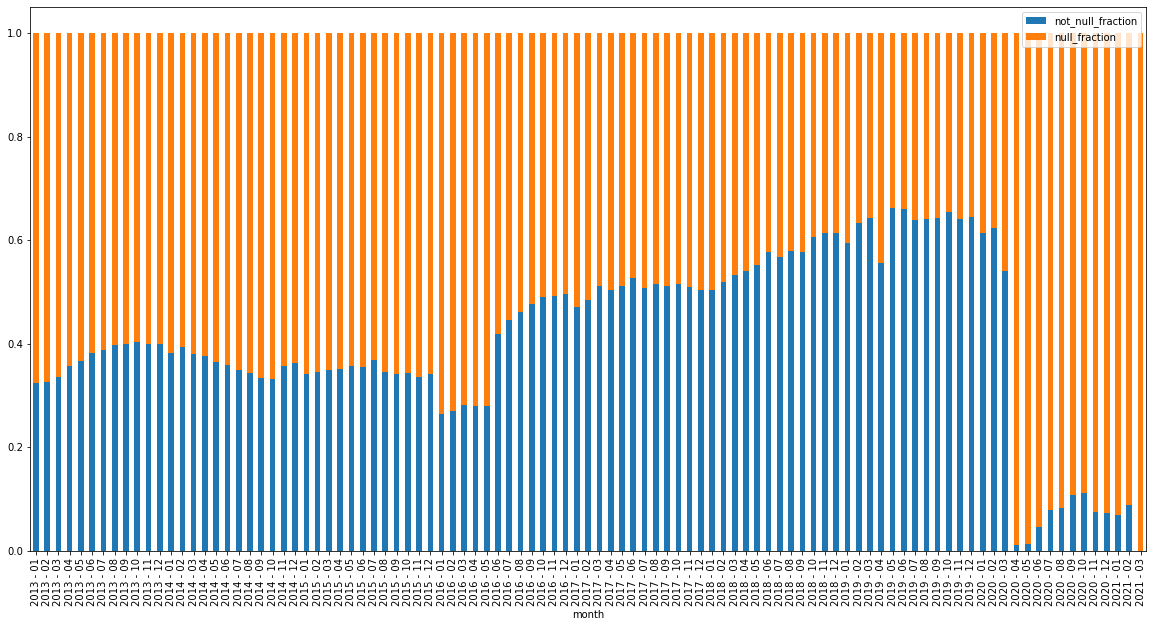

In [76]:
df_monthly.set_index("month")[["not_null_fraction", "null_fraction"]].plot.bar(figsize=(20,10), stacked=True)

In [78]:
df_total = pd.read_gbq("select count(*) as c, count(distinct(unique_key)) as duk from `bigquery-public-data.chicago_taxi_trips.taxi_trips` ")
total_trips = df_total["c"].values[0]
df_total

,c,duk
0,195147320,195147320


In [89]:
#reordering columns from less nulls to most nulls
ordered_columns = label_cols + [c for c in df_nulls.sort_values("null_count")["column"].values if c not in label_cols]

integral_null_selection=",\n".join([
    "COUNTIF(" + " OR ".join([f"{c} is null" for c in columns if c in ordered_columns[:i+1]]) + f") AS {ordered_columns[i]}"
    for i in range(len(ordered_columns))
])
punctual_null_selection = ",\n".join([
    f"COUNTIF({c} is null) as {c}" for c in ordered_columns
])
position_null_selection = ",\n".join([
    f"{i} as {c}" for i,c in enumerate(ordered_columns)
])

df_integral_nulls = timeit( lambda: pd.read_gbq(f"""select "INTEGRAL" as kind, {integral_null_selection} FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` """),"integral")
df_punctual_nulls = timeit( lambda: pd.read_gbq(f"""select "PUNCTUAL" as kind, {punctual_null_selection} FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` """),"punctual")
df_position_nulls = timeit( lambda: pd.read_gbq(f"""select "POSITION" as kind, {position_null_selection} """),"position")

integral - 0:00:10.268253
punctual - 0:00:03.674630
position - 0:00:01.426356


In [96]:
df_integral_nulls_data = pd.concat([df_integral_nulls, df_punctual_nulls, df_position_nulls]).set_index("kind")
df_integral_nulls_data = df_integral_nulls_data.T
df_integral_nulls_data["TARE"] = df_integral_nulls_data["INTEGRAL"] - df_integral_nulls_data["PUNCTUAL"]
df_integral_nulls_data = df_integral_nulls_data.sort_values("POSITION")
df_integral_nulls_data["NOT_NULLS"] = total_trips - df_integral_nulls_data["INTEGRAL"]

<AxesSubplot:>

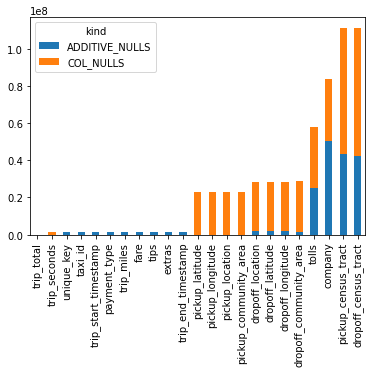

In [98]:
df_integral_nulls_data[["TARE","PUNCTUAL"]].rename(columns={"TARE":"ADDITIVE_NULLS", "PUNCTUAL":"COL_NULLS"}).plot.bar(stacked=True)

<AxesSubplot:>

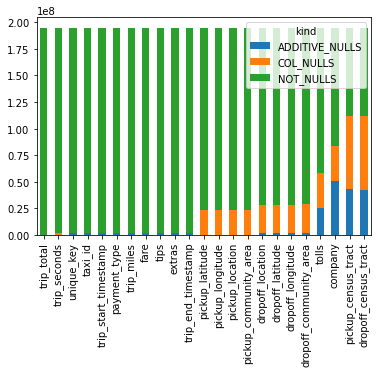

In [97]:
df_integral_nulls_data[["TARE","PUNCTUAL","NOT_NULLS"]].rename(columns={"TARE":"ADDITIVE_NULLS", "PUNCTUAL":"COL_NULLS"}).plot.bar(stacked=True)

In [92]:
df_integral_nulls_data["PUNCTUAL"]/df_integral_nulls_data["INTEGRAL"]

trip_total                1.000000
trip_seconds              0.996484
unique_key                0.000000
taxi_id                   0.000000
trip_start_timestamp      0.000000
payment_type              0.000000
trip_miles                0.001769
fare                      0.003699
tips                      0.003699
extras                    0.003699
trip_end_timestamp        0.013393
pickup_latitude           0.998504
pickup_longitude          0.998504
pickup_location           0.998504
pickup_community_area     0.998505
dropoff_location          0.939072
dropoff_latitude          0.939072
dropoff_longitude         0.939072
dropoff_community_area    0.941162
tolls                     0.569729
company                   0.399934
pickup_census_tract       0.610379
dropoff_census_tract      0.618718
dtype: float64

In [93]:
# COMPLETELY NOT NULL ROWS
print("COMPLETELY NOT NULL FRACTION: "+str((total_trips - df_integral_nulls_data["INTEGRAL"].max())/total_trips)+" ("+str(total_trips - df_integral_nulls_data["INTEGRAL"].max())+" rows)")

COMPLETELY NOT NULL FRACTION: 0.4291929809745786 (83755860 rows)


companies without null values in labels: 66


<AxesSubplot:xlabel='company'>

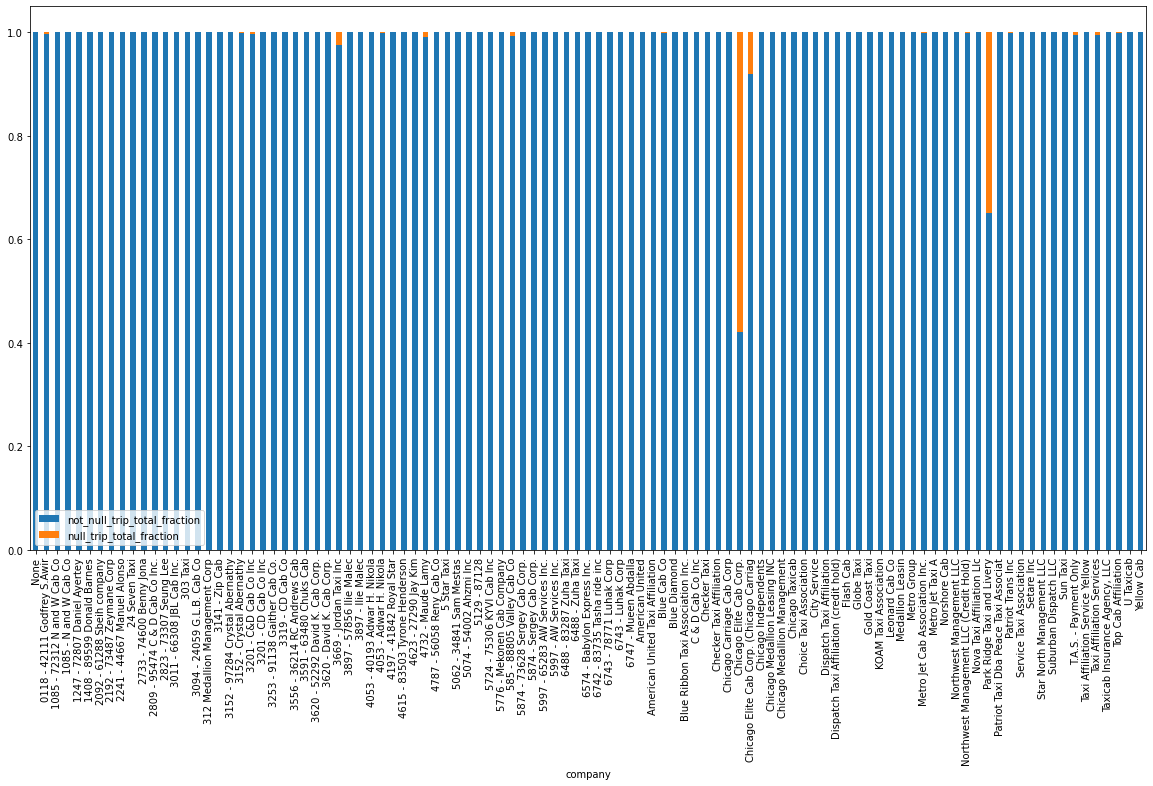

In [115]:
# null values in labels company distribution
df_company = pd.read_gbq("""
SELECT company,
countif(trip_total is null or trip_seconds is null) as null_trip_total,
countif(not(trip_total is null or trip_seconds is null)) as not_null_trip_total,
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
group by 1
order by 1
""")
df_company["null_trip_total_fraction"] = df_company["null_trip_total"] / (df_company["null_trip_total"] + df_company["not_null_trip_total"])
df_company["not_null_trip_total_fraction"] = df_company["not_null_trip_total"] / (df_company["null_trip_total"] + df_company["not_null_trip_total"])
print("companies without null values in labels: " + str(df_company[df_company["null_trip_total"] == 0].shape[0]))
df_company[df_company["null_trip_total"] != 0].set_index("company")[["not_null_trip_total_fraction","null_trip_total_fraction"]].plot.bar(figsize=(20,10), stacked=True)

<AxesSubplot:xlabel='month'>

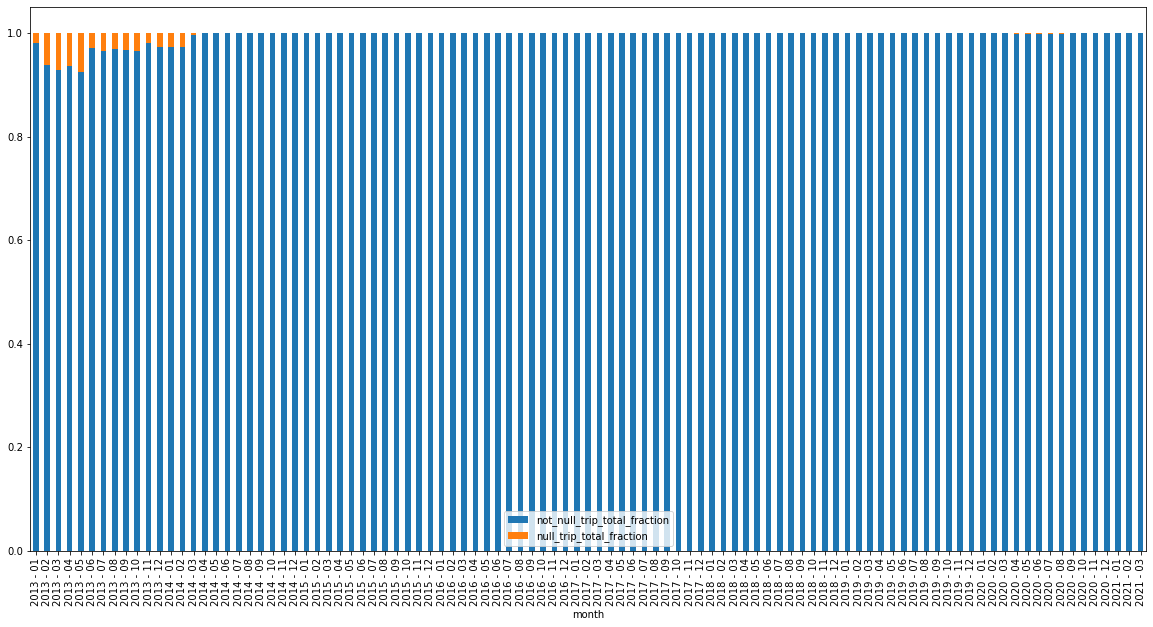

In [117]:
# null values in labels time distribution
df_company = pd.read_gbq("""
SELECT FORMAT_TIMESTAMP("%Y - %m", trip_start_timestamp) as month,
countif(trip_total is null or trip_seconds is null) as null_trip_total,
countif(not(trip_total is null or trip_seconds is null)) as not_null_trip_total,
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
group by 1
order by 1
""")
df_company["null_trip_total_fraction"] = df_company["null_trip_total"] / (df_company["null_trip_total"] + df_company["not_null_trip_total"])
df_company["not_null_trip_total_fraction"] = df_company["not_null_trip_total"] / (df_company["null_trip_total"] + df_company["not_null_trip_total"])
df_company.set_index("month")[["not_null_trip_total_fraction","null_trip_total_fraction"]].plot.bar(figsize=(20,10), stacked=True)

In [118]:
count_2013=pd.read_gbq("""select count(*) from `bigquery-public-data.chicago_taxi_trips.taxi_trips`
where FORMAT_TIMESTAMP("%Y", trip_start_timestamp) = "2013" """)
count_2013/total_trips

,f0_
0,0.139473


## Evidence
* 0.7% of records (1.298.238 trips) have null values on trip_seconds field
* 0.003% of records (4.821 trips)  have null values on trip_total field
* The following fields have a lot of null values: 
    * company
    * pickup_latitude
    * pickup_longitude
    * pickup_census_tract
    * dropoff_census_tract
    * pickup_location
    * dropoff_location
    * pickup_community_area
    * dropoff_community_area
    * tolls
* null values can be grouped as:
    * records with nulls in columns (pickup_latitude, pickup_longitude, pickup_location, pickup_community_area, dropoff_location, dropoff_latitude, dropoff_longitude, dropoff_community_area)
    * records with nulls in columns (pickup_census_tract, dropoff_census_tract)
    * records with nulls in column (company)
    * records with nulls in column (tolls)
    * others (a really small fraction)
* removing all trips with null values would result in a loss of 57% (83.755.860 trips) of the dataset 
* we could try to remove the year 2013 to remove almost all the null values form the labels, although we would lose 13% of the dataset 
  
### Filters
* we can safely remove records with null values on the label fields without losing much of the dataset

-----

**notes**: 
* from here, we will try to not reinvent what has already been done in https://www.linkedin.com/pulse/predicting-taxi-fare-chicago-cabs-thomas-synnott
* the main focus will be on the two labels of our tasks: trip_total and trip_seconds

----

# trip_total seasonality

In [119]:
df_monthly = pd.read_gbq("""
SELECT 
FORMAT_TIMESTAMP("%Y - %m", trip_start_timestamp) as month,
sum(trip_total) as total,
count(distinct unique_key) as trips,
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` 
WHERE trip_total IS NOT NULL AND trip_seconds IS NOT NULL
group by month
order by month
""")

<AxesSubplot:xlabel='month'>

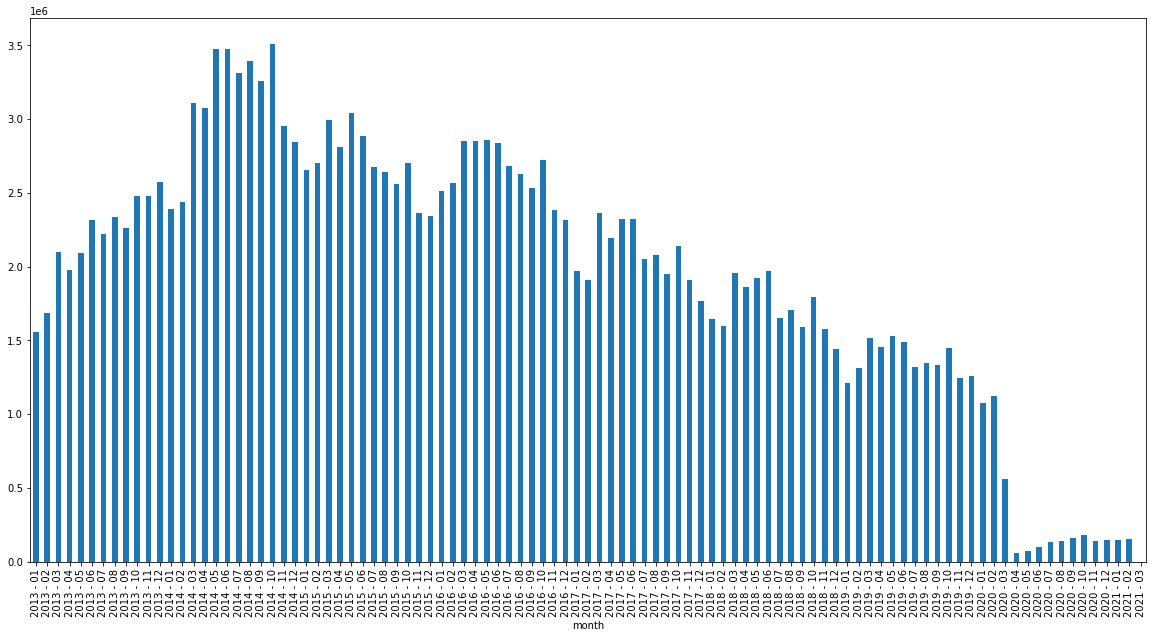

In [120]:
df_monthly.set_index("month")["trips"].plot.bar(figsize=(20,10))

<AxesSubplot:xlabel='month'>

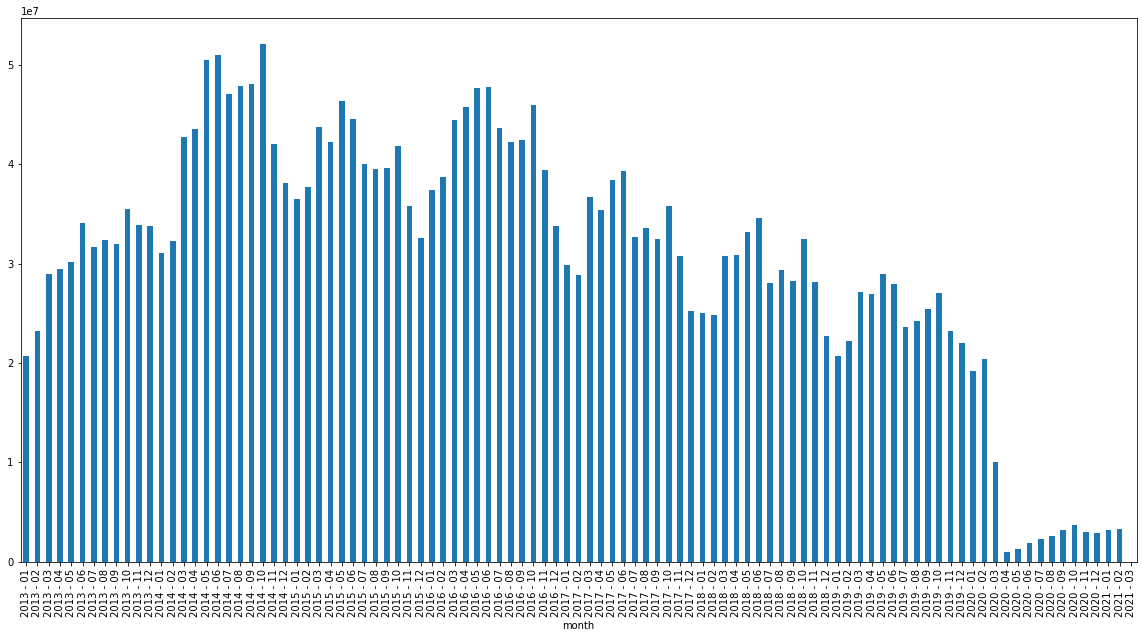

In [121]:
df_monthly.set_index("month")["total"].plot.bar(figsize=(20,10))

<AxesSubplot:xlabel='month'>

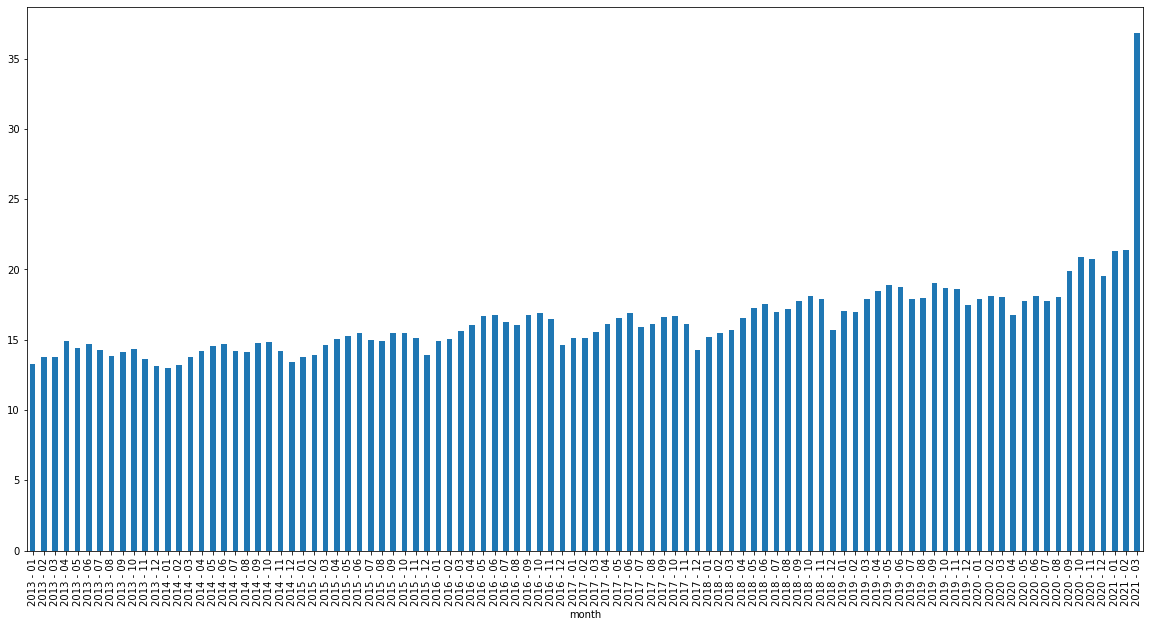

In [122]:
df_total_over_trips = df_monthly.set_index("month")["total"] / df_monthly.set_index("month")["trips"]
df_total_over_trips.plot.bar(figsize=(20,10))

## Evidence
* month of the year might be predictive
    * there seems to be some kind of seasonality, less earnings in december and more in may
    * the number of trips decreases over the years while the mean price rises

------

# trip_seconds seasonality

In [123]:
df_monthly = pd.read_gbq("""
SELECT 
FORMAT_TIMESTAMP("%Y - %m", trip_start_timestamp) as month,
sum(trip_seconds) as total,
count(distinct unique_key) as trips,
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` 
WHERE trip_total IS NOT NULL AND trip_seconds IS NOT NULL
group by month
order by month
""")

<AxesSubplot:xlabel='month'>

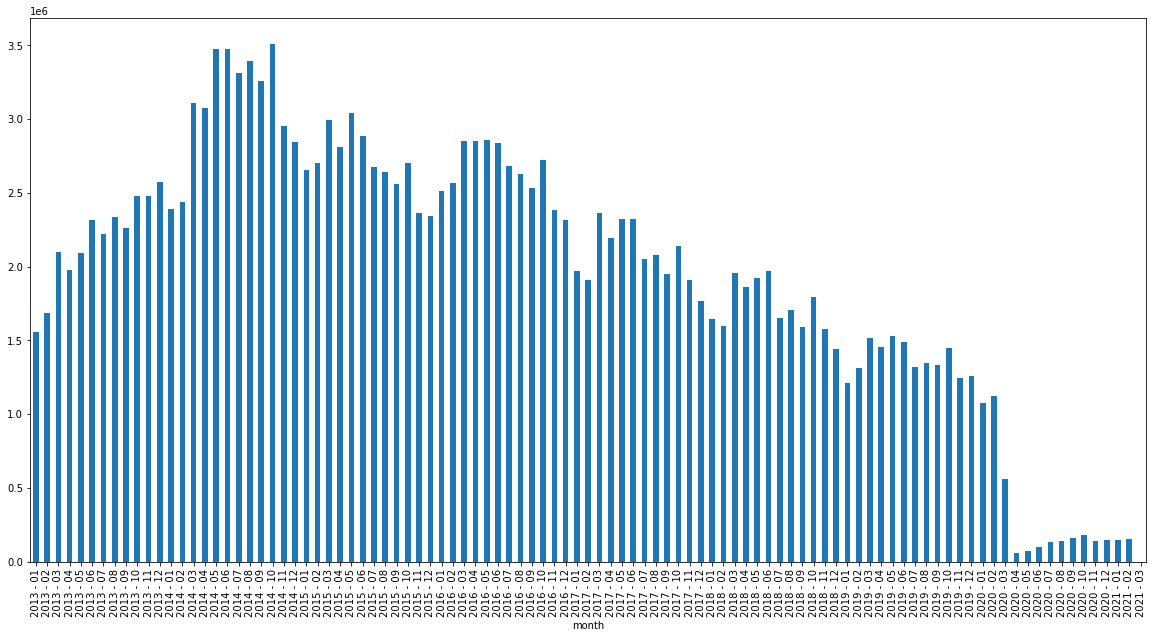

In [124]:
df_monthly.set_index("month")["trips"].plot.bar(figsize=(20,10))

<AxesSubplot:xlabel='month'>

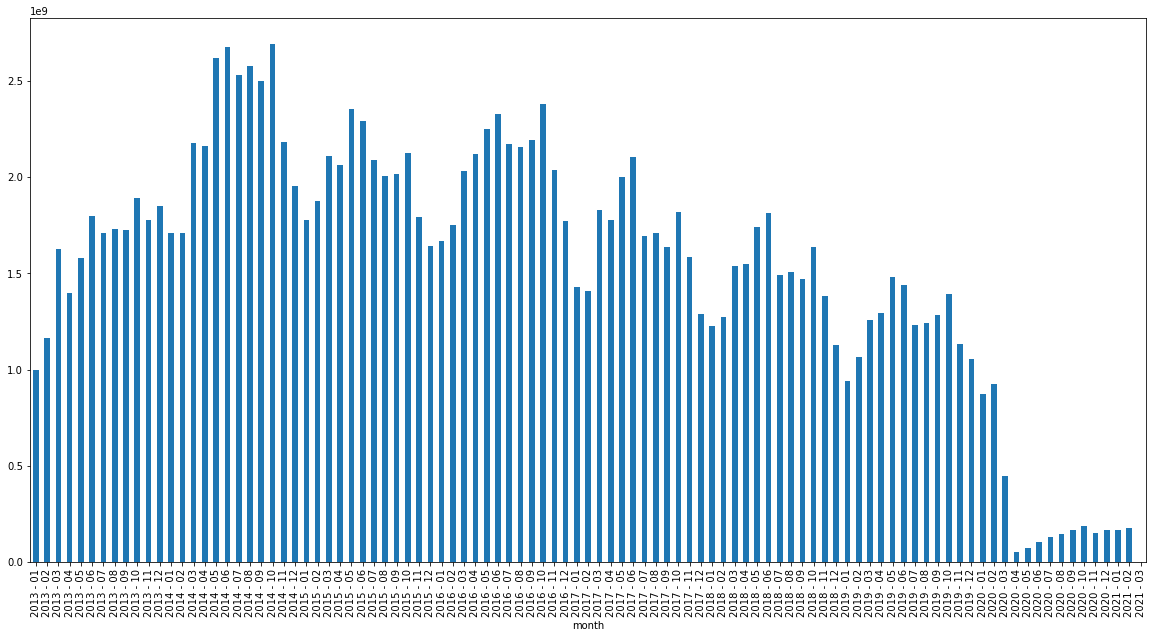

In [125]:
df_monthly.set_index("month")["total"].plot.bar(figsize=(20,10))

<AxesSubplot:xlabel='month'>

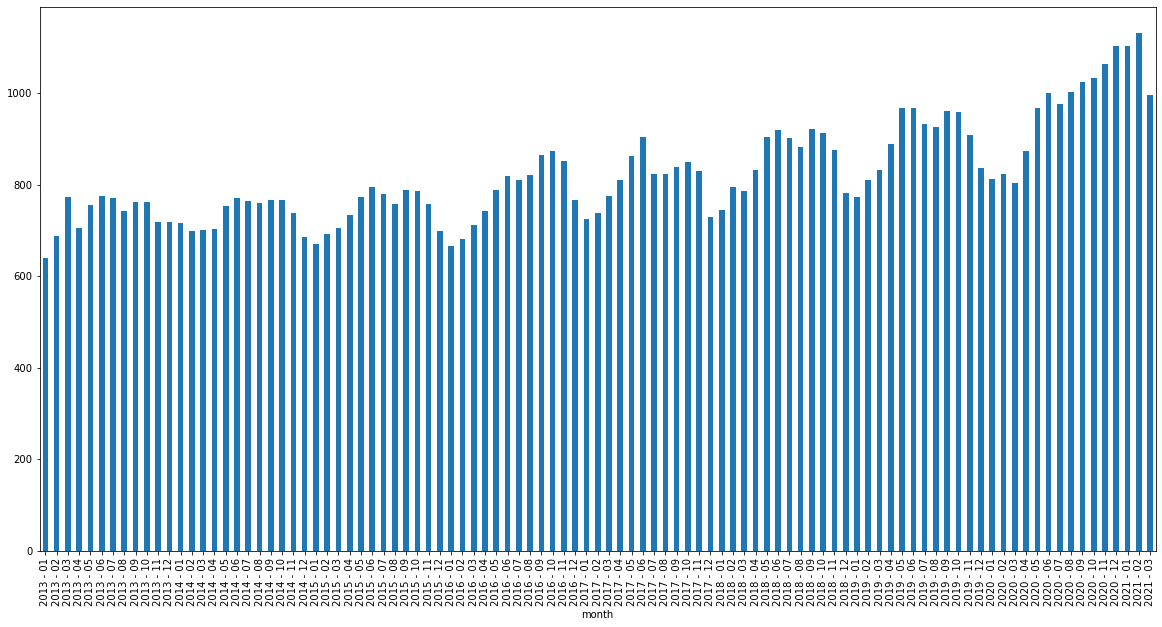

In [126]:
df_total_over_trips = df_monthly.set_index("month")["total"] / df_monthly.set_index("month")["trips"]
df_total_over_trips.plot.bar(figsize=(20,10))

In [128]:
count_2020_2021=pd.read_gbq("""select count(*) from `bigquery-public-data.chicago_taxi_trips.taxi_trips`
where FORMAT_TIMESTAMP("%Y", trip_start_timestamp) in ("2020", "2021") """)
count_2020_2021/total_trips

,f0_
0,0.021479


## Evidence
* Month of the year might be predictive
    * there seems to be some kind of seasonality, shorter trips in december/january and longer trips in june/july
    * the number of trips decreases over the years while the mean duration slightly rises
    
## Evidence on both label distributions
* The influence of COVID19 is highly visible in the number of trips of 2020-2021 WRT the other years.
    * we could build a model trained on data until 2018, and test it against both 2019 AND 2020/2021, then discuss differences in model performances over the distribution shift due to COVID19

--------

# trip_total distribution

0:00:01.557527
records fraction: 0.9933239206154612 (193844501 rows)


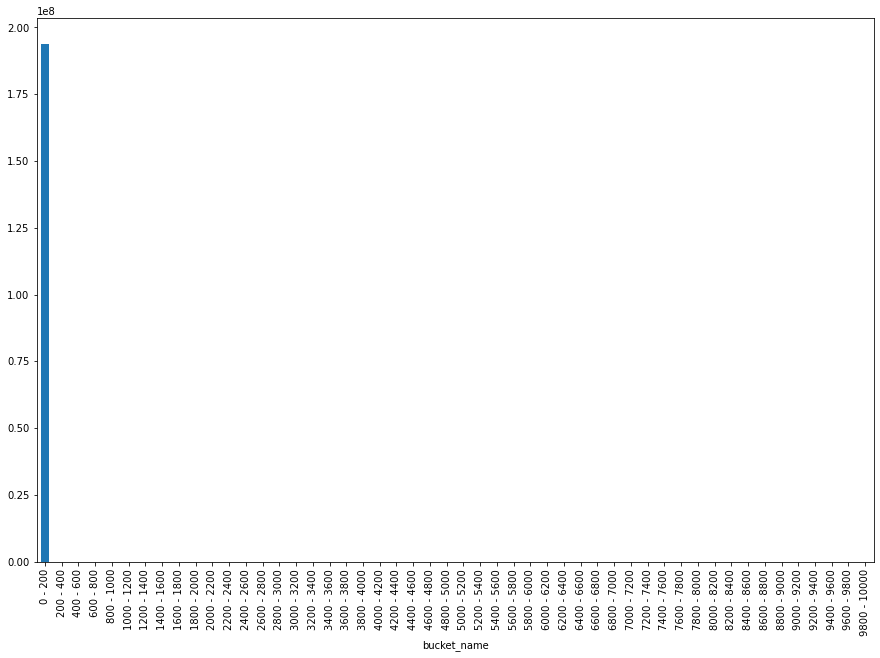

In [212]:
num_buckets=50
min_trip_total = 0
max_trip_total = 10000 #"(select max(trip_total)+1 from `bigquery-public-data.chicago_taxi_trips.taxi_trips`)"

step = int((max_trip_total-min_trip_total)/num_buckets)
query_buckets = """
SELECT bucket, count(*) as value from (
SELECT
CASE """+"\n".join([
    f"""WHEN trip_total >= {i} AND trip_total < {i+step} THEN CONCAT("{str(pos).zfill(2)} _ ", "{i}-{i+step}") """
    for pos,i in enumerate(range(min_trip_total,max_trip_total,step))
])+f""" END AS bucket
from `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE trip_total IS NOT NULL AND trip_seconds IS NOT NULL
AND trip_total < {max_trip_total} AND trip_total >= {min_trip_total}
) GROUP BY bucket order by bucket
"""
df_buckets = timeit( lambda: pd.read_gbq(query_buckets))
df_buckets["position"   ] = df_buckets["bucket"].str.split(" _ ").str[0]
df_buckets["min_limit"  ] = df_buckets["bucket"].str.split(" _ ").str[1].str.split("-").str[0].apply(float).apply(int)
df_buckets["max_limit"  ] = df_buckets["bucket"].str.split(" _ ").str[1].str.split("-").str[1].apply(float).apply(int)
df_buckets["bucket_name"] = df_buckets["min_limit"].apply(str) + " - " + df_buckets["max_limit"].apply(str)
df_buckets.sort_values("position").set_index("bucket_name")["value"].plot.bar(figsize=(15,10))
print("records fraction: "+str((df_buckets["value"].sum())/total_trips)+" ("+str(df_buckets["value"].sum())+" rows)")

0:00:01.847651
records fraction: 0.9932334658759341 (193826849 rows)


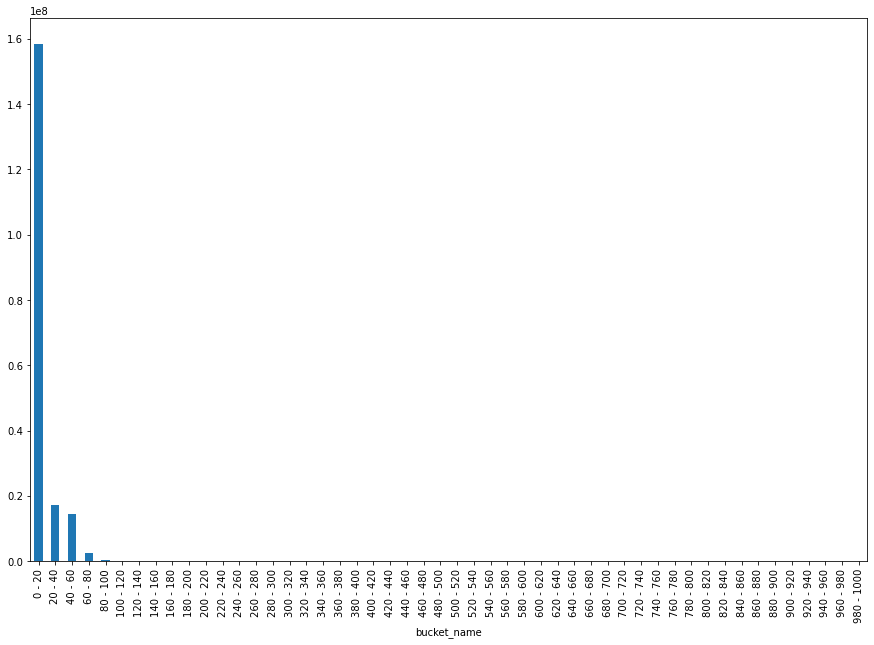

In [213]:
num_buckets=50
min_trip_total = 0
max_trip_total = 1000 #"(select max(trip_total)+1 from `bigquery-public-data.chicago_taxi_trips.taxi_trips`)"

step = int((max_trip_total-min_trip_total)/num_buckets)
query_buckets = """
SELECT bucket, count(*) as value from (
SELECT
CASE """+"\n".join([
    f"""WHEN trip_total >= {i} AND trip_total < {i+step} THEN CONCAT("{str(pos).zfill(2)} _ ", "{i}-{i+step}") """
    for pos,i in enumerate(range(min_trip_total,max_trip_total,step))
])+f""" END AS bucket
from `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE trip_total IS NOT NULL AND trip_seconds IS NOT NULL
AND trip_total < {max_trip_total} AND trip_total >= {min_trip_total}
) GROUP BY bucket order by bucket
"""
df_buckets = timeit( lambda: pd.read_gbq(query_buckets))
df_buckets["position"   ] = df_buckets["bucket"].str.split(" _ ").str[0]
df_buckets["min_limit"  ] = df_buckets["bucket"].str.split(" _ ").str[1].str.split("-").str[0].apply(float).apply(int)
df_buckets["max_limit"  ] = df_buckets["bucket"].str.split(" _ ").str[1].str.split("-").str[1].apply(float).apply(int)
df_buckets["bucket_name"] = df_buckets["min_limit"].apply(str) + " - " + df_buckets["max_limit"].apply(str)
df_buckets.sort_values("position").set_index("bucket_name")["value"].plot.bar(figsize=(15,10))
print("records fraction: "+str((df_buckets["value"].sum())/total_trips)+" ("+str(df_buckets["value"].sum())+" rows)")

0:00:01.786131
records fraction: 9.045473952704039e-05 (17652 rows)


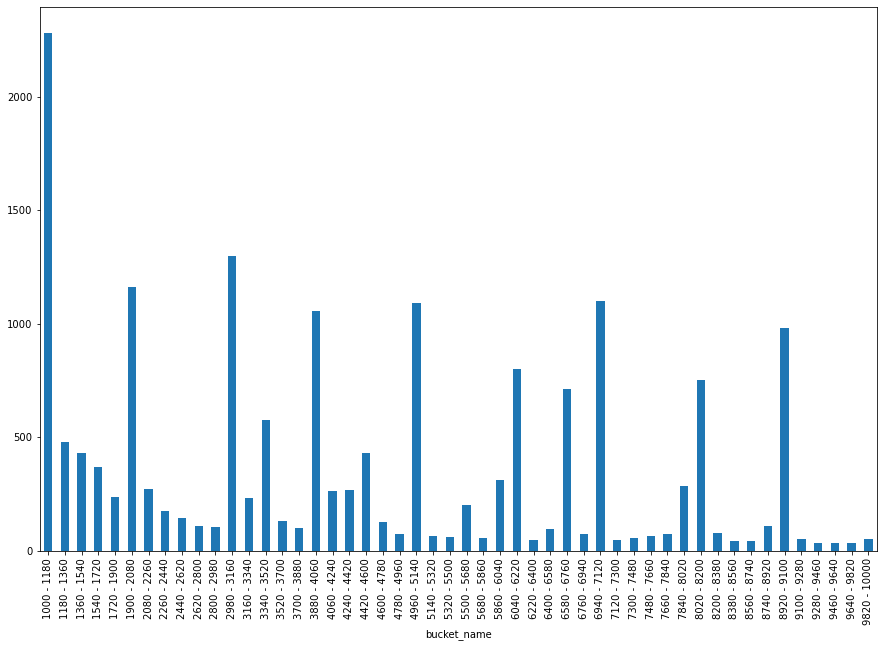

In [214]:
num_buckets=50
min_trip_total = 1000
max_trip_total = 10000 #"(select max(trip_total)+1 from `bigquery-public-data.chicago_taxi_trips.taxi_trips`)"

step = int((max_trip_total-min_trip_total)/num_buckets)
query_buckets = """
SELECT bucket, count(*) as value from (
SELECT
CASE """+"\n".join([
    f"""WHEN trip_total >= {i} AND trip_total < {i+step} THEN CONCAT("{str(pos).zfill(2)} _ ", "{i}-{i+step}") """
    for pos,i in enumerate(range(min_trip_total,max_trip_total,step))
])+f""" END AS bucket
from `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE trip_total IS NOT NULL AND trip_seconds IS NOT NULL
AND trip_total < {max_trip_total} AND trip_total >= {min_trip_total}
) GROUP BY bucket order by bucket
"""
df_buckets = timeit( lambda: pd.read_gbq(query_buckets))
df_buckets["position"   ] = df_buckets["bucket"].str.split(" _ ").str[0]
df_buckets["min_limit"  ] = df_buckets["bucket"].str.split(" _ ").str[1].str.split("-").str[0].apply(float).apply(int)
df_buckets["max_limit"  ] = df_buckets["bucket"].str.split(" _ ").str[1].str.split("-").str[1].apply(float).apply(int)
df_buckets["bucket_name"] = df_buckets["min_limit"].apply(str) + " - " + df_buckets["max_limit"].apply(str)
df_buckets.sort_values("position").set_index("bucket_name")["value"].plot.bar(figsize=(15,10))
print("records fraction: "+str((df_buckets["value"].sum())/total_trips)+" ("+str(df_buckets["value"].sum())+" rows)")

0:00:01.392830
records fraction: 0.991384365411731 (193466002 rows)


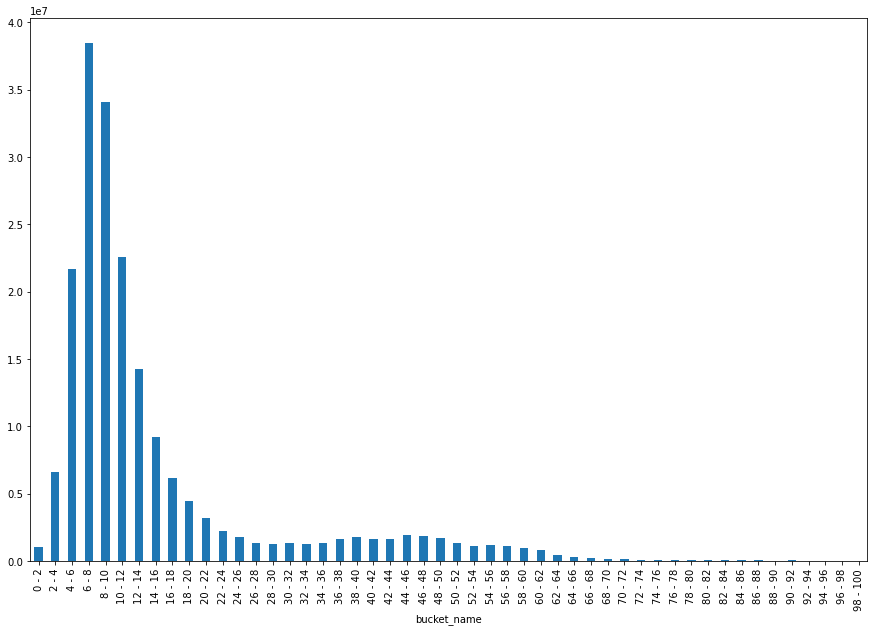

In [215]:
num_buckets=50
min_trip_total = 0
max_trip_total = 100 #"(select max(trip_total)+1 from `bigquery-public-data.chicago_taxi_trips.taxi_trips`)"

step = int((max_trip_total-min_trip_total)/num_buckets)
query_buckets = """
SELECT bucket, count(*) as value from (
SELECT
CASE """+"\n".join([
    f"""WHEN trip_total >= {i} AND trip_total < {i+step} THEN CONCAT("{str(pos).zfill(2)} _ ", "{i}-{i+step}") """
    for pos,i in enumerate(range(min_trip_total,max_trip_total,step))
])+f""" END AS bucket
from `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE trip_total IS NOT NULL AND trip_seconds IS NOT NULL
AND trip_total < {max_trip_total} AND trip_total >= {min_trip_total}
) GROUP BY bucket order by bucket
"""
df_buckets = timeit( lambda: pd.read_gbq(query_buckets))
df_buckets["position"   ] = df_buckets["bucket"].str.split(" _ ").str[0]
df_buckets["min_limit"  ] = df_buckets["bucket"].str.split(" _ ").str[1].str.split("-").str[0].apply(float).apply(int)
df_buckets["max_limit"  ] = df_buckets["bucket"].str.split(" _ ").str[1].str.split("-").str[1].apply(float).apply(int)
df_buckets["bucket_name"] = df_buckets["min_limit"].apply(str) + " - " + df_buckets["max_limit"].apply(str)
df_buckets.sort_values("position").set_index("bucket_name")["value"].plot.bar(figsize=(15,10))
print("records fraction: "+str((df_buckets["value"].sum())/total_trips)+" ("+str(df_buckets["value"].sum())+" rows)")

In [170]:
free_trips = pd.read_gbq("select count(*) from `bigquery-public-data.chicago_taxi_trips.taxi_trips` where trip_total = 0").values[0]
print("free trips records fraction: "+str(free_trips/total_trips)+" ("+str(free_trips)+" rows)")

free trips records fraction: [0.00134304] ([262091] rows)


## Evidence
* trip_total has normal distribution around the value 7, and a very long right queue up to the value 10000
* 0.1% of records have a trip_total value of 0
* 1% of records have a trip_total grater than 1000

### Filters
* We may filter out trip_total=0 and outliers such as trip_total > 1000

# trip_total distribution in log scale

0:00:01.757030


<AxesSubplot:xlabel='bucket_name'>

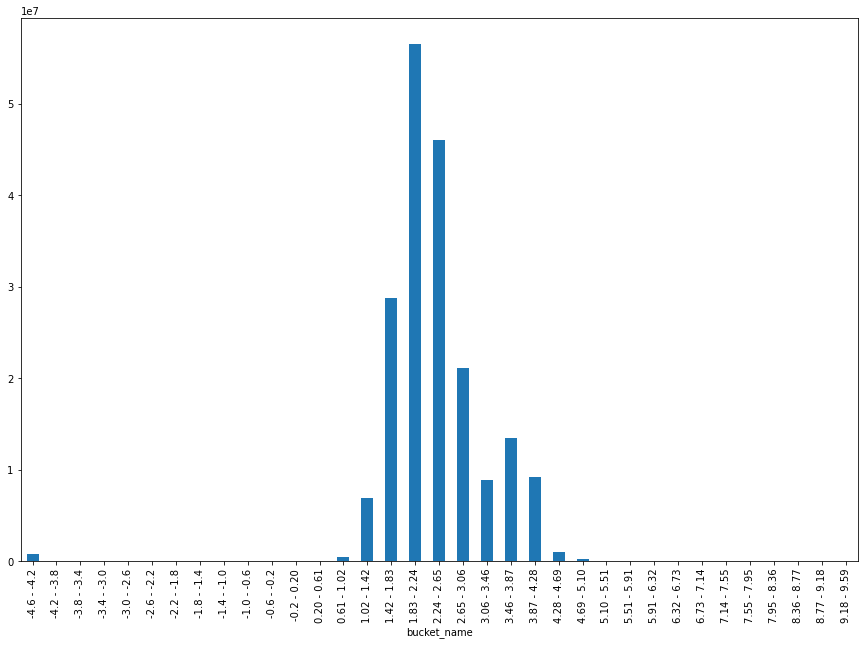

In [216]:
num_buckets=50
min_trip_total = -10
max_trip_total = 10 #"(select max(trip_total)+1 from `bigquery-public-data.chicago_taxi_trips.taxi_trips`)"

limits = zip(
    np.linspace(min_trip_total,max_trip_total,num_buckets)[:-1],
    np.linspace(min_trip_total,max_trip_total,num_buckets)[1:]
)

query_buckets = """
SELECT bucket, count(*) as value from (
SELECT
CASE """+"\n".join([
    f"""WHEN ln(trip_total) >= {i_min} AND ln(trip_total) < {i_max} THEN CONCAT("{str(pos).zfill(2)} _ ", "{i_min} - {i_max}") """
    for pos,(i_min,i_max) in enumerate(limits)
])+f""" END AS bucket
from `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE trip_total IS NOT NULL AND trip_seconds IS NOT NULL
AND trip_total > 0
AND ln(trip_total) < {max_trip_total} AND ln(trip_total) >= {min_trip_total}
) GROUP BY bucket order by bucket
"""
df_buckets = timeit( lambda: pd.read_gbq(query_buckets))
df_buckets["position"   ] = df_buckets["bucket"].str.split(" _ ").str[0]
df_buckets["min_limit"  ] = df_buckets["bucket"].str.split(" _ ").str[1].str.split(" - ").str[0].apply(float).apply(lambda x: str(x)[:4])
df_buckets["max_limit"  ] = df_buckets["bucket"].str.split(" _ ").str[1].str.split(" - ").str[1].apply(float).apply(lambda x: str(x)[:4])
df_buckets["bucket_name"] = df_buckets["min_limit"].apply(str) + " - " + df_buckets["max_limit"].apply(str)
df_buckets.sort_values("position").set_index("bucket_name")["value"].plot.bar(figsize=(15,10))

## Evidence
* we may obtain better results by using ln(trip_total) as target instead of trip_total
* another option is to bucketize trip_total on an exponential scale

----

# trip_seconds distribution

0:00:01.313877
records fraction: 0.9933239206154612 (193844501 rows)


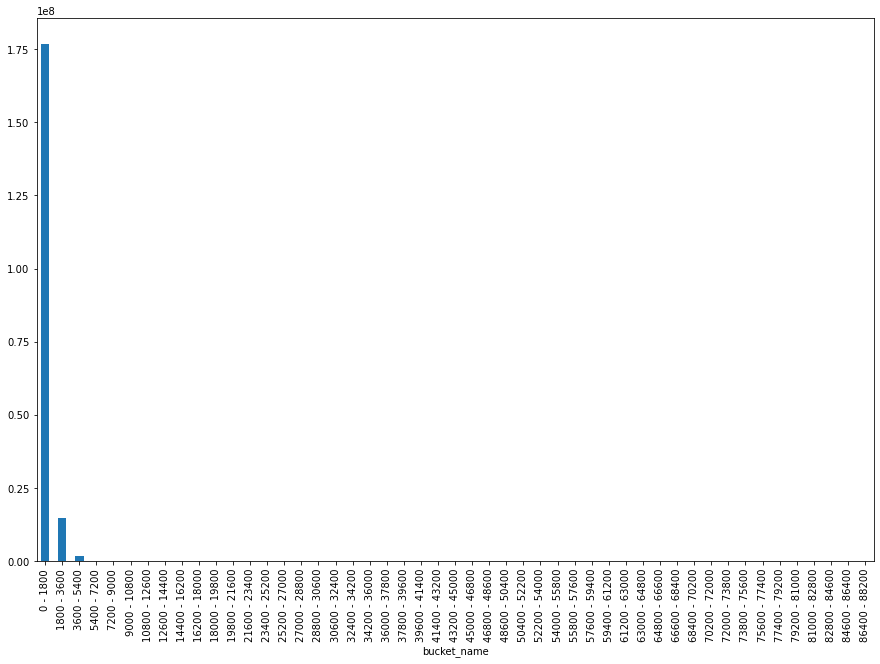

In [217]:
num_buckets=50
min_trip_seconds = 0
max_trip_seconds = 25*60*60 #more than a day 

step = int((max_trip_seconds-min_trip_seconds)/num_buckets)
query_buckets = """
SELECT bucket, count(*) as value from (
SELECT
CASE """+"\n".join([
    f"""WHEN trip_seconds >= {i} AND trip_seconds < {i+step} THEN CONCAT("{str(pos).zfill(2)} _ ", "{i}-{i+step}") """
    for pos,i in enumerate(range(min_trip_seconds,max_trip_seconds,step))
])+f""" END AS bucket
from `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE trip_total IS NOT NULL AND trip_seconds IS NOT NULL
AND trip_seconds < {max_trip_seconds} AND trip_seconds >= {min_trip_seconds}
) GROUP BY bucket order by bucket
"""
df_buckets = timeit( lambda: pd.read_gbq(query_buckets))
df_buckets["position"   ] = df_buckets["bucket"].str.split(" _ ").str[0]
df_buckets["min_limit"  ] = df_buckets["bucket"].str.split(" _ ").str[1].str.split("-").str[0].apply(float).apply(int)
df_buckets["max_limit"  ] = df_buckets["bucket"].str.split(" _ ").str[1].str.split("-").str[1].apply(float).apply(int)
df_buckets["bucket_name"] = df_buckets["min_limit"].apply(str) + " - " + df_buckets["max_limit"].apply(str)
df_buckets.sort_values("position").set_index("bucket_name")["value"].plot.bar(figsize=(15,10))
print("records fraction: "+str((df_buckets["value"].sum())/total_trips)+" ("+str(df_buckets["value"].sum())+" rows)")

0:00:01.248678
records fraction: 0.9921947582984998 (193624148 rows)


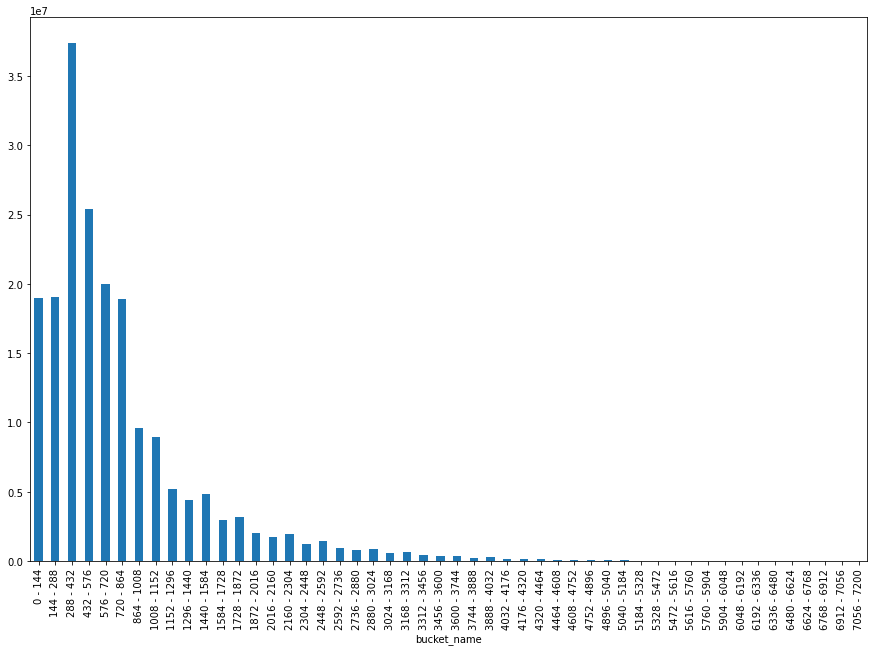

In [218]:
num_buckets=50
min_trip_seconds = 0
max_trip_seconds = 2*60*60 #two hours 

step = int((max_trip_seconds-min_trip_seconds)/num_buckets)
query_buckets = """
SELECT bucket, count(*) as value from (
SELECT
CASE """+"\n".join([
    f"""WHEN trip_seconds >= {i} AND trip_seconds < {i+step} THEN CONCAT("{str(pos).zfill(2)} _ ", "{i}-{i+step}") """
    for pos,i in enumerate(range(min_trip_seconds,max_trip_seconds,step))
])+f""" END AS bucket
from `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE trip_total IS NOT NULL AND trip_seconds IS NOT NULL
AND trip_seconds < {max_trip_seconds} AND trip_seconds >= {min_trip_seconds}
) GROUP BY bucket order by bucket
"""
df_buckets = timeit( lambda: pd.read_gbq(query_buckets))
df_buckets["position"   ] = df_buckets["bucket"].str.split(" _ ").str[0]
df_buckets["min_limit"  ] = df_buckets["bucket"].str.split(" _ ").str[1].str.split("-").str[0].apply(float).apply(int)
df_buckets["max_limit"  ] = df_buckets["bucket"].str.split(" _ ").str[1].str.split("-").str[1].apply(float).apply(int)
df_buckets["bucket_name"] = df_buckets["min_limit"].apply(str) + " - " + df_buckets["max_limit"].apply(str)
df_buckets.sort_values("position").set_index("bucket_name")["value"].plot.bar(figsize=(15,10))
print("records fraction: "+str((df_buckets["value"].sum())/total_trips)+" ("+str(df_buckets["value"].sum())+" rows)")

0:00:01.302312
records fraction: 0.0011291623169613603 (220353 rows)


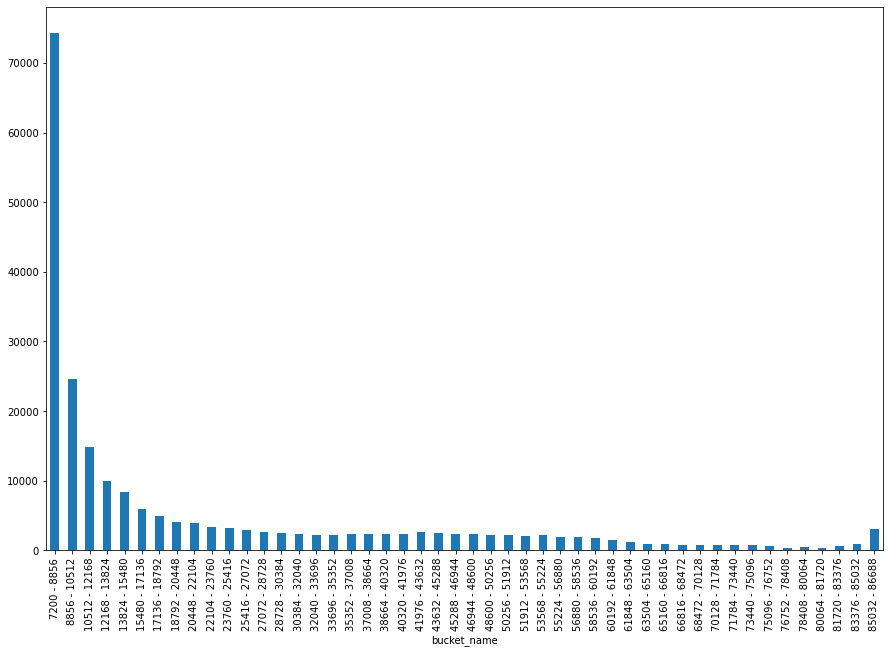

In [223]:
num_buckets=50
min_trip_seconds = 2*60*60 #two hours
max_trip_seconds = 25*60*60 #more than a day 

step = int((max_trip_seconds-min_trip_seconds)/num_buckets)
query_buckets = """
SELECT bucket, count(*) as value from (
SELECT
CASE """+"\n".join([
    f"""WHEN trip_seconds >= {i} AND trip_seconds < {i+step} THEN CONCAT("{str(pos).zfill(2)} _ ", "{i}-{i+step}") """
    for pos,i in enumerate(range(min_trip_seconds,max_trip_seconds,step))
])+f""" END AS bucket
from `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE trip_total IS NOT NULL AND trip_seconds IS NOT NULL
AND trip_seconds < {max_trip_seconds} AND trip_seconds >= {min_trip_seconds}
) GROUP BY bucket order by bucket
"""
df_buckets = timeit( lambda: pd.read_gbq(query_buckets))
df_buckets["position"   ] = df_buckets["bucket"].str.split(" _ ").str[0]
df_buckets["min_limit"  ] = df_buckets["bucket"].str.split(" _ ").str[1].str.split("-").str[0].apply(float).apply(int)
df_buckets["max_limit"  ] = df_buckets["bucket"].str.split(" _ ").str[1].str.split("-").str[1].apply(float).apply(int)
df_buckets["bucket_name"] = df_buckets["min_limit"].apply(str) + " - " + df_buckets["max_limit"].apply(str)
df_buckets.sort_values("position").set_index("bucket_name")["value"].plot.bar(figsize=(15,10))
print("records fraction: "+str((df_buckets["value"].sum())/total_trips)+" ("+str(df_buckets["value"].sum())+" rows)")

In [224]:
teleports = pd.read_gbq("select count(*) from `bigquery-public-data.chicago_taxi_trips.taxi_trips` where trip_seconds = 0").values[0]
print("teleport records fraction: "+str(teleports/total_trips)+" ("+str(teleports)+" rows)")

teleport records fraction: [0.05311557] ([10365361] rows)


## Evidence
* trip_seconds has normal distribution around the value 300 (5 minutes), and a very long right queue up to the value 86400 (one day)
* 5% of records have a trip_seconds value of 0
* 0.1% of records have a trip_seconds grater than 7200 (two hours)

### Filters
* We may filter out trip_seconds=0 and outliers such as trip_seconds > 7200

0:00:08.836729


<AxesSubplot:xlabel='bucket_name'>

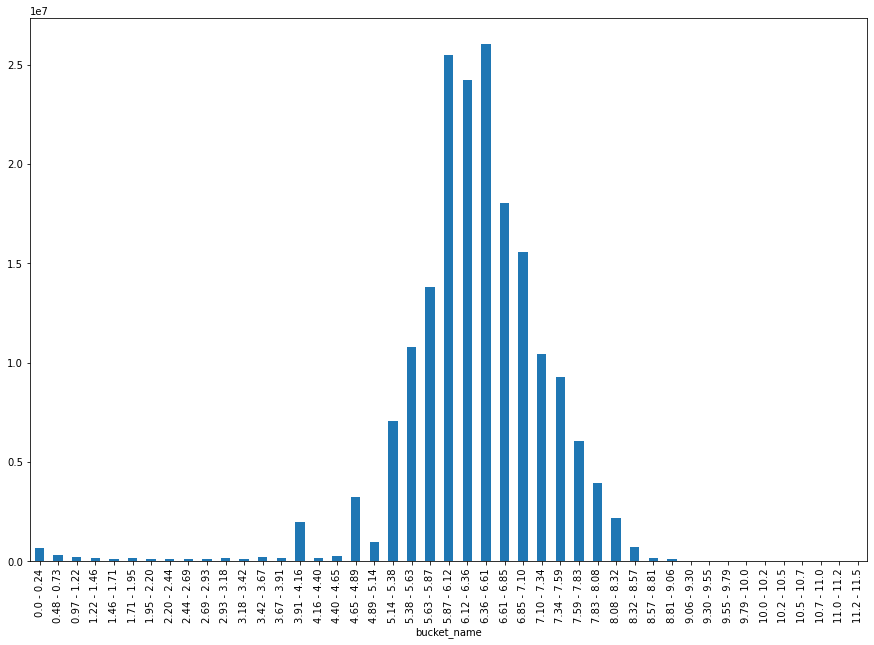

In [226]:
num_buckets=50
min_trip_seconds = 0
max_trip_seconds = 12 #"(select max(trip_total)+1 from `bigquery-public-data.chicago_taxi_trips.taxi_trips`)"

limits = zip(
    np.linspace(min_trip_seconds,max_trip_seconds,num_buckets)[:-1],
    np.linspace(min_trip_seconds,max_trip_seconds,num_buckets)[1:]
)

query_buckets = """
SELECT bucket, count(*) as value from (
SELECT
CASE """+"\n".join([
    f"""WHEN ln(trip_seconds) >= {i_min} AND ln(trip_seconds) < {i_max} THEN CONCAT("{str(pos).zfill(2)} _ ", "{i_min} - {i_max}") """
    for pos,(i_min,i_max) in enumerate(limits)
])+f""" END AS bucket
from `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE trip_total IS NOT NULL AND trip_seconds IS NOT NULL
AND trip_seconds > 0
AND ln(trip_seconds) < {max_trip_seconds} AND ln(trip_seconds) >= {min_trip_seconds}
) GROUP BY bucket order by bucket
"""
df_buckets = timeit( lambda: pd.read_gbq(query_buckets))
df_buckets["position"   ] = df_buckets["bucket"].str.split(" _ ").str[0]
df_buckets["min_limit"  ] = df_buckets["bucket"].str.split(" _ ").str[1].str.split(" - ").str[0].apply(float).apply(lambda x: str(x)[:4])
df_buckets["max_limit"  ] = df_buckets["bucket"].str.split(" _ ").str[1].str.split(" - ").str[1].apply(float).apply(lambda x: str(x)[:4])
df_buckets["bucket_name"] = df_buckets["min_limit"].apply(str) + " - " + df_buckets["max_limit"].apply(str)
df_buckets.sort_values("position").set_index("bucket_name")["value"].plot.bar(figsize=(15,10))

## Evidence
* we may obtain better results by using ln(trip_seconds) as target instead of trip_seconds
* another option is to bucketize trip_seconds on an exponential scale

-----

# Correlation between numerical columns
**note**: a common practice is to use the traveled distance as a good feature, let's see if this still holds in the dataset with 2019,2020 and 2021 data

In [30]:
df_corr = pd.read_gbq("""
WITH 
distances AS (
SELECT unique_key,
SQRT(POW(dropoff_latitude-pickup_latitude,2) + POW(dropoff_longitude-pickup_longitude,2)) AS euclidean_distance,
ABS(dropoff_latitude-pickup_latitude) + ABS(dropoff_longitude-pickup_longitude)           AS manhattan_distance
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`   
),
numerical_data AS (
SELECT colname, value, unique_key FROM (
(SELECT 'trip_start_timestamp' AS colname, UNIX_SECONDS(trip_start_timestamp)         AS value, unique_key FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` ) UNION ALL
(SELECT 'trip_end_timestamp'   AS colname, UNIX_SECONDS(trip_end_timestamp)           AS value, unique_key FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` ) UNION ALL
(SELECT 'trip_month'           AS colname, EXTRACT(MONTH FROM trip_start_timestamp)   AS value, unique_key FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` ) UNION ALL
(SELECT 'trip_miles'           AS colname, trip_miles                                 AS value, unique_key FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` ) UNION ALL
(SELECT 'fare'                 AS colname, fare                                       AS value, unique_key FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` ) UNION ALL
(SELECT 'tips'                 AS colname, tips                                       AS value, unique_key FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` ) UNION ALL
(SELECT 'tolls'                AS colname, tolls                                      AS value, unique_key FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` ) UNION ALL
(SELECT 'extras'               AS colname, extras                                     AS value, unique_key FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` ) UNION ALL
(SELECT 'euclidean_distance'   AS colname, euclidean_distance                         AS value, unique_key FROM distances                                            ) UNION ALL
(SELECT 'manhattan_distance'   AS colname, manhattan_distance                         AS value, unique_key FROM distances                                            ) UNION ALL
(SELECT 'trip_seconds'         AS colname, trip_seconds                               AS value, unique_key FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` ) UNION ALL
(SELECT 'trip_total'           AS colname, trip_total                                 AS value, unique_key FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` )
)
)

SELECT   CORR(a.value, b.value) as corr, 
         a.colname              as col1, 
         b.colname              as col2
FROM     numerical_data a
JOIN     numerical_data b
ON       a.unique_key=b.unique_key
GROUP BY a.colname, b.colname 
""")

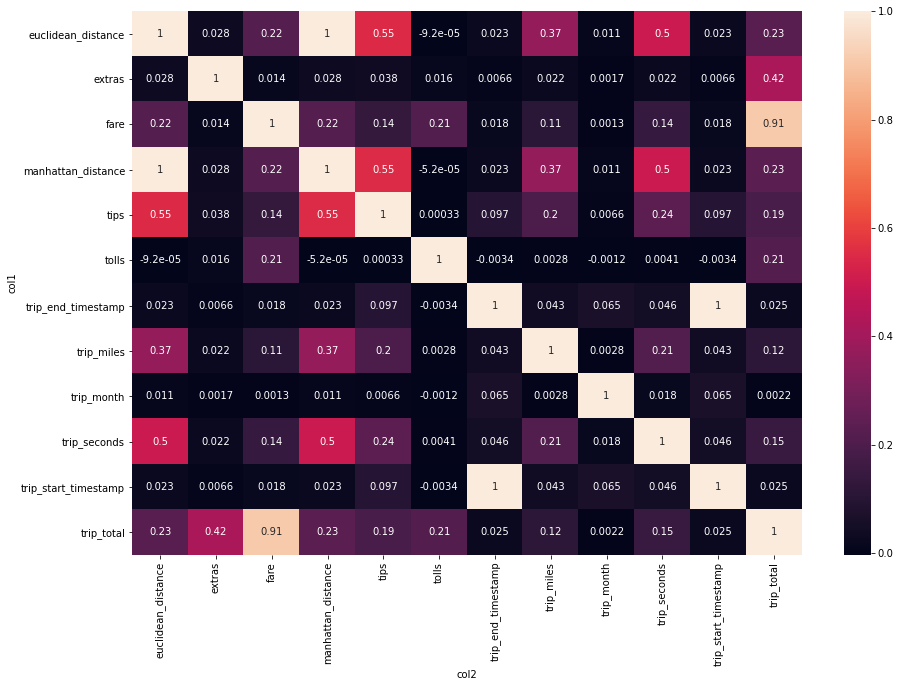

In [37]:
df_corr_mat = df_corr.pivot("col1", "col2", "corr")
plt.figure(figsize=(15,10))
ax = sns.heatmap(df_corr_mat, annot=True)

## Evidence
* trip_seconds is positively correlated with distance, as expected
* unexpectedly, trip_total is less correlated with distance, and much more correlated with extras and fares
    * It seems like the total depends more on other factors, maybe on the zone/company?
    * maybe there is a minimum fee that acts as bias?

-----

In [45]:
# correlation between categoricals: 
# https://datascience.stackexchange.com/questions/51591/what-measures-can-i-use-to-find-correlation-between-categorical-features-and-bin

# Labels distribution across time
Let's see how the distribution of the labels varies monthly in a more specific way

## Temporal distribution of trip_total values, bucketized over trips

In [4]:
df_limits = pd.read_gbq("""
    select 
    min(trip_total) as min_trip_total,
    max(trip_total) as max_trip_total,
    min(trip_seconds) as min_trip_seconds,
    max(trip_seconds) as max_trip_seconds,
    from `bigquery-public-data.chicago_taxi_trips.taxi_trips`
""")

In [5]:
df_limits

,min_trip_total,max_trip_total,min_trip_seconds,max_trip_seconds
0,0.0,9999.99,0,86400


In [34]:
num_buckets=16
label = "trip_total"

# at this point we know that label values are better represented on a logarithmic scale
limits = zip(
    np.logspace(0,np.log10(df_limits[f"max_{label}"].values[0]),num_buckets+1)[:-1],
    np.logspace(0,np.log10(df_limits[f"max_{label}"].values[0]),num_buckets+1)[1:]
)

query = """
SELECT 
FORMAT_TIMESTAMP("%Y - %m", trip_start_timestamp) as month,
"""+",\n".join([
    f"countif({label} >= {min_val} and {label} < {max_val}) as bucket{str(i).zfill(2)}_{int(min_val)}_{int(max_val)}"
    for i, (min_val, max_val) in enumerate(limits)
])+"""
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` 
WHERE trip_total IS NOT NULL AND trip_seconds IS NOT NULL
group by month
order by month
"""

df_monthly=pd.read_gbq(query)

<AxesSubplot:xlabel='month'>

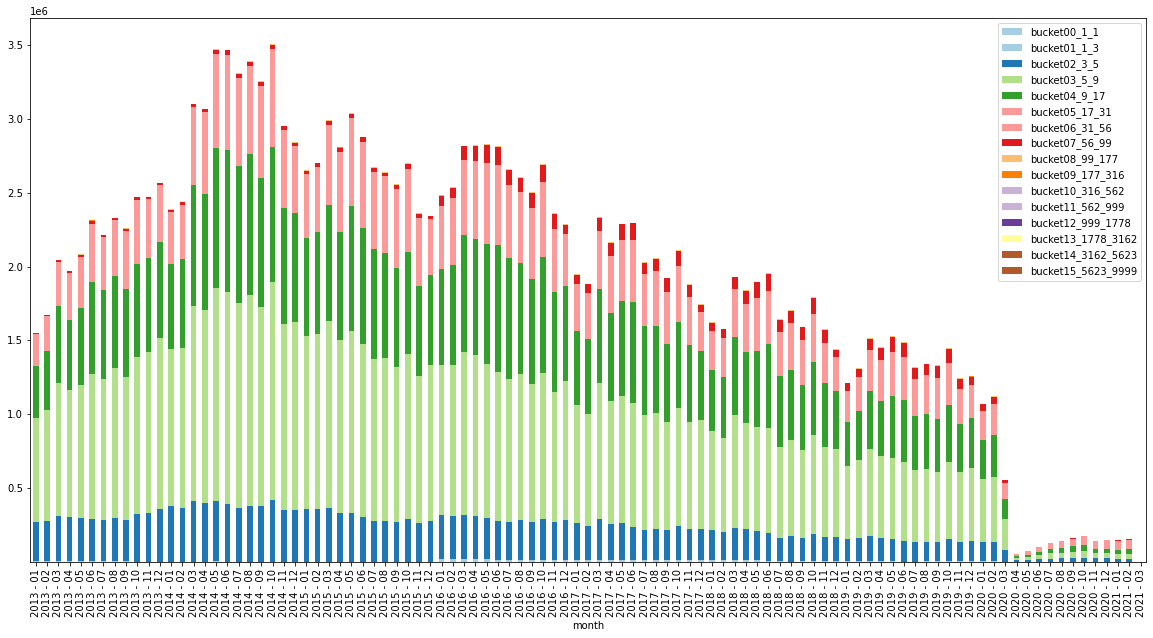

In [42]:
df_monthly.set_index("month")[[c for c in df_monthly.columns if c.startswith("bucket")]].plot.bar(figsize=(20,10), stacked=True, colormap='Paired')

## Temporal distribution of trip_seconds values, bucketized over trips

In [43]:
num_buckets=16
label = "trip_seconds"

# at this point we know that label values are better represented on a logarithmic scale
limits = zip(
    np.logspace(0,np.log10(df_limits[f"max_{label}"].values[0]),num_buckets+1)[:-1],
    np.logspace(0,np.log10(df_limits[f"max_{label}"].values[0]),num_buckets+1)[1:]
)

query = """
SELECT 
FORMAT_TIMESTAMP("%Y - %m", trip_start_timestamp) as month,
"""+",\n".join([
    f"countif({label} >= {min_val} and {label} < {max_val}) as bucket{str(i).zfill(2)}_{int(min_val)}_{int(max_val)}"
    for i, (min_val, max_val) in enumerate(limits)
])+"""
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` 
WHERE trip_total IS NOT NULL AND trip_seconds IS NOT NULL
group by month
order by month
"""

df_monthly=pd.read_gbq(query)

<AxesSubplot:xlabel='month'>

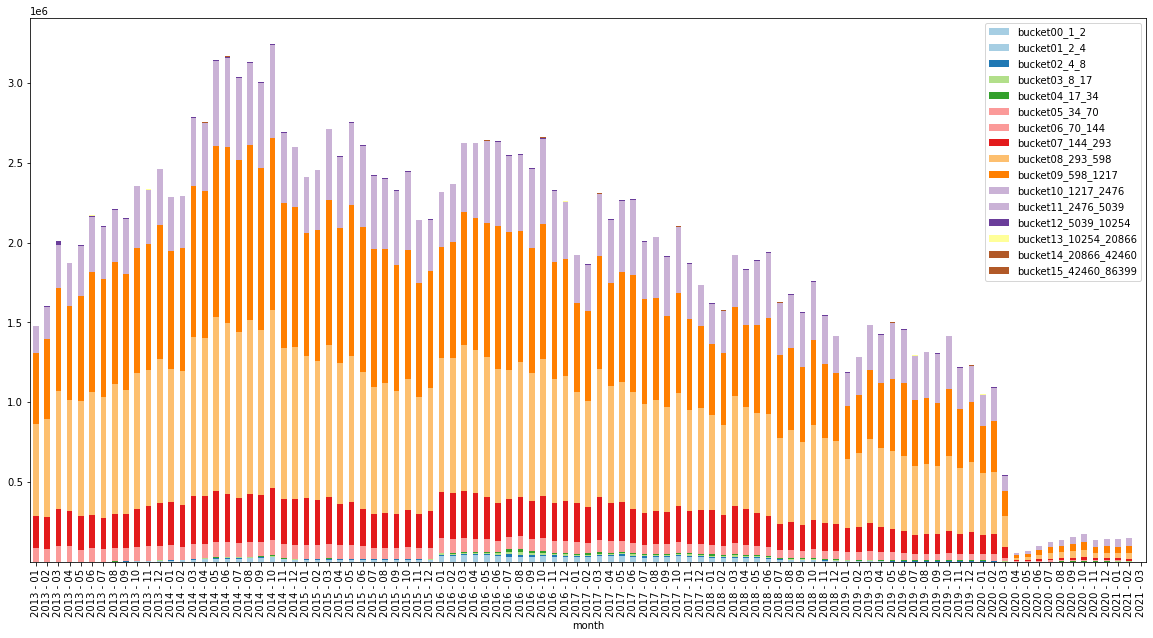

In [44]:
df_monthly.set_index("month")[[c for c in df_monthly.columns if c.startswith("bucket")]].plot.bar(figsize=(20,10), stacked=True, colormap='Paired')

## Evidence
* monthly and yearly distribution of values for both labels seem to not change much.
* 2020 and 2021 are peculiar cases, but even then the distributions seems to hold fairly still

### Conclusion:
* We could consider to split the dataset by year, using trips up to 2018 as train/eval set and trips from 2019 as test set to see how well the model generalizes to future trips.
* We could also test the performance of the model on 2020 and 2021 to see if the generalization holds on years affected by the presence of COVID19